Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
x_train shape: torch.Size([50000, 3, 32, 32])
50000 train samples
10000 test samples
Autoencoder parameters: 344,197
Training Autoencoder...
Epoch [1/25], Train Loss: 0.0395, Val Loss: 0.0370
Epoch [6/25], Train Loss: 0.0365, Val Loss: 0.0367
Epoch [11/25], Train Loss: 0.0363, Val Loss: 0.0365
Epoch [16/25], Train Loss: 0.0362, Val Loss: 0.0364
Epoch [21/25], Train Loss: 0.0361, Val Loss: 0.0362


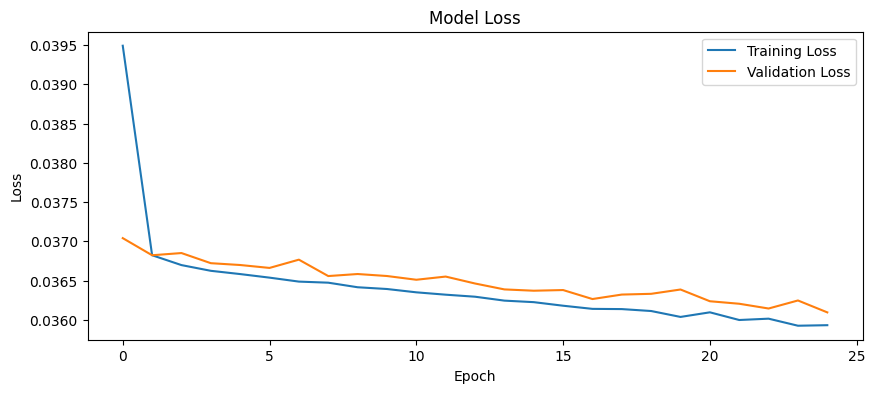

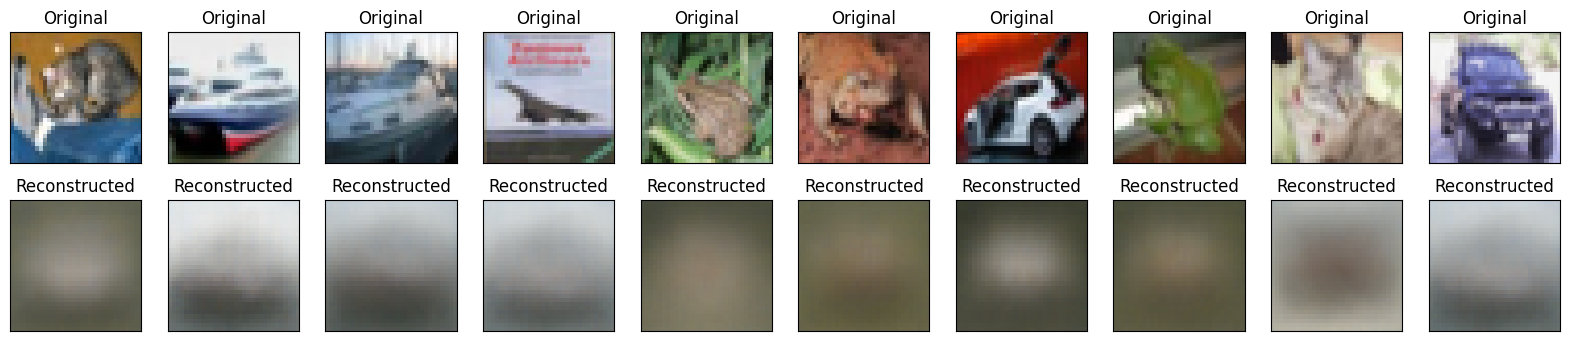

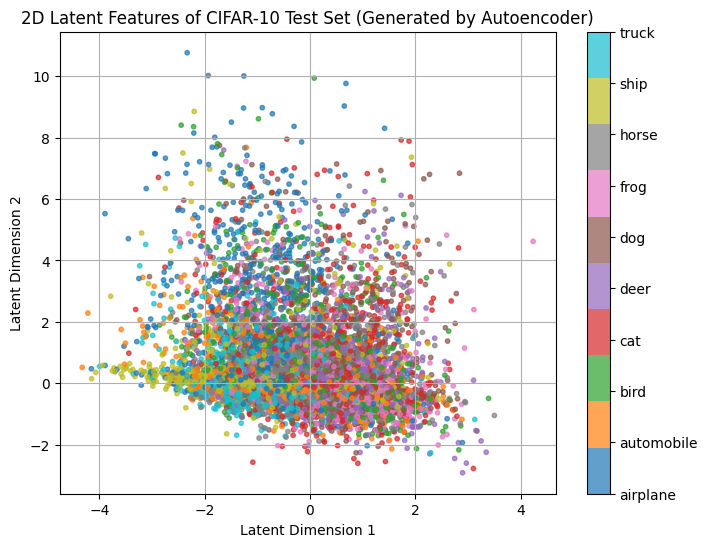


Loading VGG16...


/home/hci-lab/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hci-lab/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/hci-lab/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [02:33<00:00, 3.61MB/s] 


Setting layer trainability...
Trainable parameters: 133,087,218 / 138,362,674

Starting fine-tuning...
Epoch [1/10], Train Loss: 1.1720, Train Acc: 58.90%, Val Acc: 71.13%
Epoch [2/10], Train Loss: 0.7356, Train Acc: 74.33%, Val Acc: 74.80%
Epoch [3/10], Train Loss: 0.6266, Train Acc: 78.36%, Val Acc: 76.63%
Epoch [4/10], Train Loss: 0.5532, Train Acc: 80.96%, Val Acc: 77.85%
Epoch [5/10], Train Loss: 0.4946, Train Acc: 82.93%, Val Acc: 78.40%
Epoch [6/10], Train Loss: 0.4456, Train Acc: 84.66%, Val Acc: 79.52%
Epoch [7/10], Train Loss: 0.4022, Train Acc: 86.23%, Val Acc: 80.01%
Epoch [8/10], Train Loss: 0.3619, Train Acc: 87.65%, Val Acc: 79.85%
Epoch [9/10], Train Loss: 0.3252, Train Acc: 89.04%, Val Acc: 80.15%
Epoch [10/10], Train Loss: 0.2899, Train Acc: 90.52%, Val Acc: 80.59%
Extracting fine-tuned features...
Shape of fine-tuned features: (10000, 512)

Applying PCA to reduce dimensions to 2...
PCA features shape: (10000, 2)

Applying t-SNE on all 10,000 samples. This may take a 

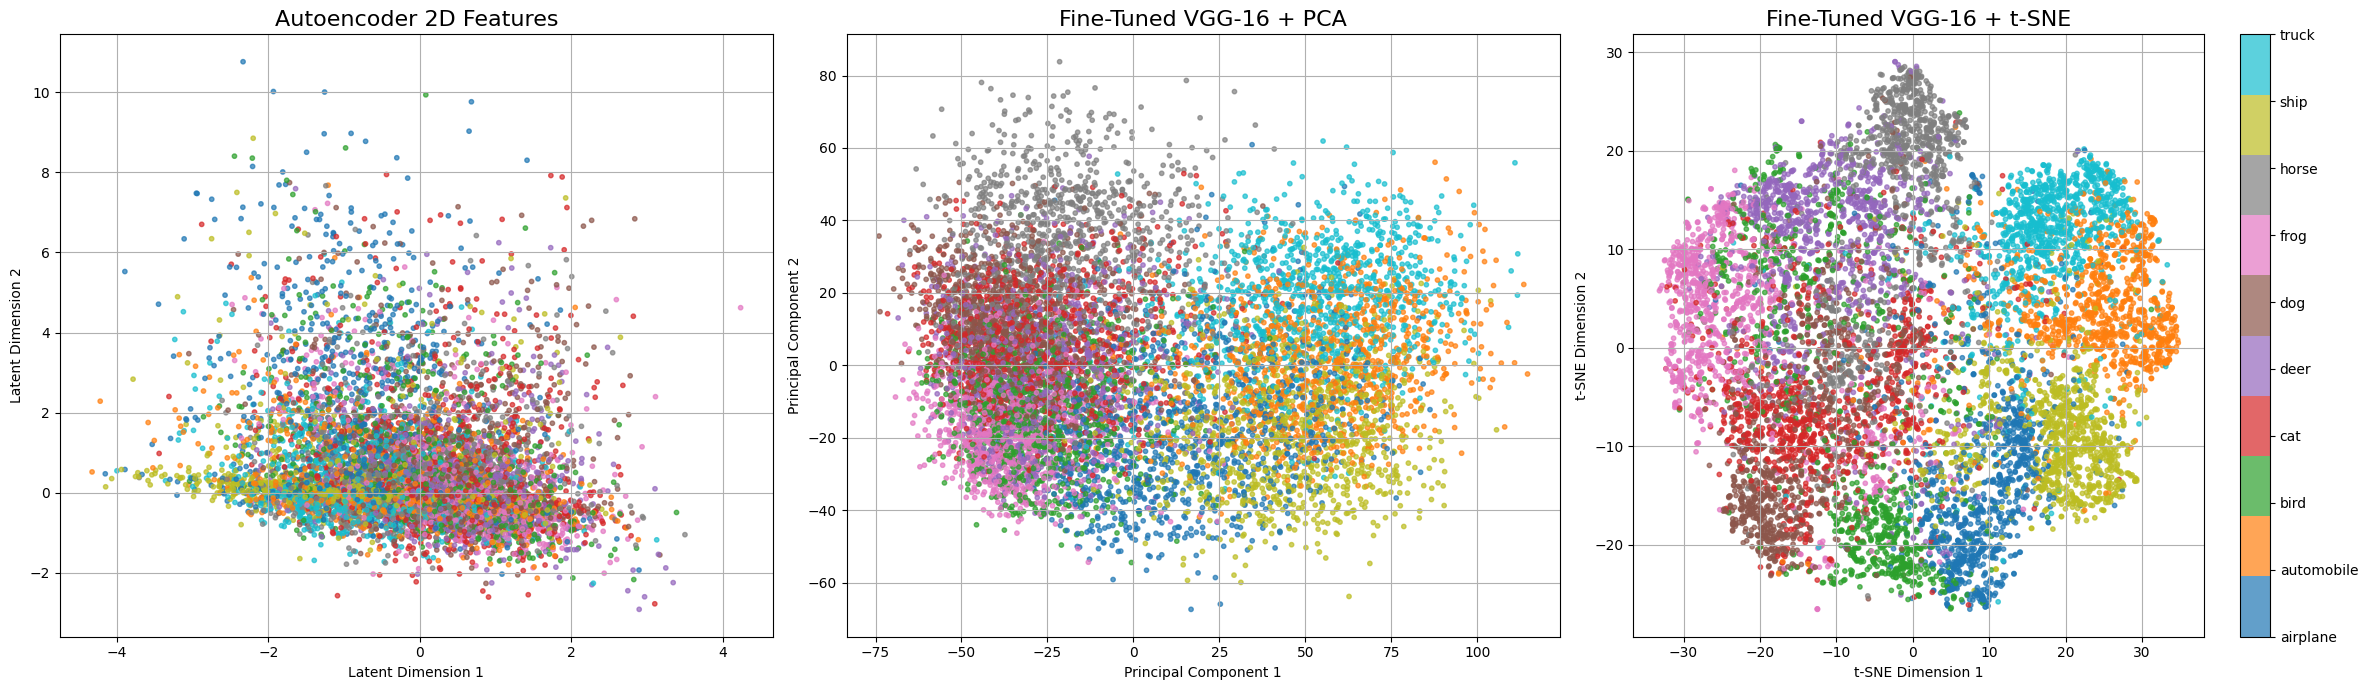


Comparison completed!
The three visualizations show:
1. Autoencoder 2D Features: Direct 2D latent space representation
2. Fine-Tuned VGG-16 + PCA: PCA reduction of VGG16 features
3. Fine-Tuned VGG-16 + t-SNE: t-SNE reduction of VGG16 features


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Get full datasets as tensors
x_train = train_dataset.data.astype('float32') / 255.0
x_test = test_dataset.data.astype('float32') / 255.0
y_train = np.array(train_dataset.targets)
y_test = np.array(test_dataset.targets)

# Convert to PyTorch tensors and rearrange dimensions from HWC to CHW
x_train = torch.from_numpy(x_train).permute(0, 3, 1, 2)
x_test = torch.from_numpy(x_test).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

LATENT_DIM = 2

class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)  # 16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # 4x4
        
        # Calculate the size after convolutions: 4*4*128 = 2048
        self.fc = nn.Linear(128 * 4 * 4, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.conv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)  # 8x8
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)   # 16x16
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)    # 32x32
        self.conv4 = nn.Conv2d(32, 3, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 4, 4)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize autoencoder
autoencoder = Autoencoder(LATENT_DIM).to(device)
print(f"Autoencoder parameters: {sum(p.numel() for p in autoencoder.parameters()):,}")

# Training setup
optimizer = optim.Adam(autoencoder.parameters())
criterion = nn.MSELoss()

# Training loop
print("Training Autoencoder...")
train_losses = []
val_losses = []

for epoch in range(25):
    # Training
    autoencoder.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed = autoencoder(data)
        loss = criterion(reconstructed, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            reconstructed = autoencoder(data)
            val_loss += criterion(reconstructed, data).item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/25], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Generate reconstructions
autoencoder.eval()
with torch.no_grad():
    x_test_tensor = x_test.to(device)
    reconstructed_imgs = autoencoder(x_test_tensor).cpu()

# Visualize reconstructions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].permute(1, 2, 0))
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].permute(1, 2, 0))
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Extract latent features
with torch.no_grad():
    latent_features = autoencoder.encoder(x_test.to(device)).cpu().numpy()

# Plot 2D latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_features[:, 0], latent_features[:, 1], c=y_test.numpy(),
                      alpha=0.7, s=10, cmap='tab10')
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.ax.set_yticklabels(class_names)
plt.title('2D Latent Features of CIFAR-10 Test Set (Generated by Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

# Fine-tuned VGG16
print("\nLoading VGG16...")
vgg16_model = vgg16(pretrained=True)

# Modify VGG16 for CIFAR-10
class FineTunedVGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(FineTunedVGG16, self).__init__()
        # Load pretrained VGG16
        self.vgg16 = vgg16(pretrained=True)
        
        # Remove the last fully connected layers
        self.features = self.vgg16.features
        
        # Freeze early layers (all but last 10)
        total_layers = len(list(self.features.children()))
        for i, child in enumerate(self.features.children()):
            if i < total_layers - 10:
                for param in child.parameters():
                    param.requires_grad = False
            else:
                for param in child.parameters():
                    param.requires_grad = True
        
        # Add global average pooling and classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        features = self.features(x)
        pooled = self.global_avg_pool(features)
        flattened = pooled.view(pooled.size(0), -1)
        output = self.classifier(flattened)
        return output
    
    def extract_features(self, x):
        """Extract features before the classifier"""
        with torch.no_grad():
            features = self.features(x)
            return features

# Initialize fine-tuned model
fine_tune_model = FineTunedVGG16().to(device)

print("Setting layer trainability...")
trainable_params = sum(p.numel() for p in fine_tune_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in fine_tune_model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")

# Setup for fine-tuning
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, fine_tune_model.parameters()), lr=1e-5)
criterion_ft = nn.CrossEntropyLoss()

# Create data loaders for fine-tuning
train_dataset_ft = TensorDataset(x_train, y_train)
test_dataset_ft = TensorDataset(x_test, y_test)
train_loader_ft = DataLoader(train_dataset_ft, batch_size=64, shuffle=True)
test_loader_ft = DataLoader(test_dataset_ft, batch_size=64, shuffle=False)

print("\nStarting fine-tuning...")
fine_tune_model.train()

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader_ft):
        data, targets = data.to(device), targets.to(device)
        
        optimizer_ft.zero_grad()
        outputs = fine_tune_model(data)
        loss = criterion_ft(outputs, targets)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    # Validation
    fine_tune_model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    
    with torch.no_grad():
        for data, targets in test_loader_ft:
            data, targets = data.to(device), targets.to(device)
            outputs = fine_tune_model(data)
            val_loss += criterion_ft(outputs, targets).item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    train_acc = 100. * correct / total
    val_acc = 100. * val_correct / val_total
    
    print(f'Epoch [{epoch+1}/10], Train Loss: {running_loss/len(train_loader_ft):.4f}, '
          f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    
    fine_tune_model.train()

# Extract features using fine-tuned VGG16
print("Extracting fine-tuned features...")
fine_tune_model.eval()
vgg_features_list = []

with torch.no_grad():
    for i in range(0, len(x_test), 64):  # Process in batches
        batch = x_test[i:i+64].to(device)
        features = fine_tune_model.extract_features(batch)
        vgg_features_list.append(features.cpu())

vgg_features_tuned = torch.cat(vgg_features_list, dim=0)
vgg_features_tuned_flat = vgg_features_tuned.view(vgg_features_tuned.size(0), -1).numpy()
print("Shape of fine-tuned features:", vgg_features_tuned_flat.shape)

# Apply PCA
print("\nApplying PCA to reduce dimensions to 2...")
pca_tuned = PCA(n_components=2)
pca_features_tuned = pca_tuned.fit_transform(vgg_features_tuned_flat)
print("PCA features shape:", pca_features_tuned.shape)

# Apply t-SNE
print("\nApplying t-SNE on all 10,000 samples. This may take a while...")
tsne_tuned = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=500, random_state=42)
tsne_features_tuned = tsne_tuned.fit_transform(vgg_features_tuned_flat)
print("t-SNE features shape:", tsne_features_tuned.shape)

# Final comparison plot
plt.figure(figsize=(24, 7))

plt.subplot(1, 3, 1)
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=y_test.numpy(),
            alpha=0.7, s=10, cmap='tab10')
plt.title('Autoencoder 2D Features', fontsize=16)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(pca_features_tuned[:, 0], pca_features_tuned[:, 1], c=y_test.numpy(),
            alpha=0.7, s=10, cmap='tab10')
plt.title('Fine-Tuned VGG-16 + PCA', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

ax3 = plt.subplot(1, 3, 3)
scatter = ax3.scatter(tsne_features_tuned[:, 0], tsne_features_tuned[:, 1], c=y_test.numpy(),
                      alpha=0.7, s=10, cmap='tab10')
plt.title('Fine-Tuned VGG-16 + t-SNE', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

cbar = plt.colorbar(scatter, ax=ax3, ticks=range(10))
cbar.ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()

print("\nComparison completed!")
print("The three visualizations show:")
print("1. Autoencoder 2D Features: Direct 2D latent space representation")
print("2. Fine-Tuned VGG-16 + PCA: PCA reduction of VGG16 features")
print("3. Fine-Tuned VGG-16 + t-SNE: t-SNE reduction of VGG16 features")